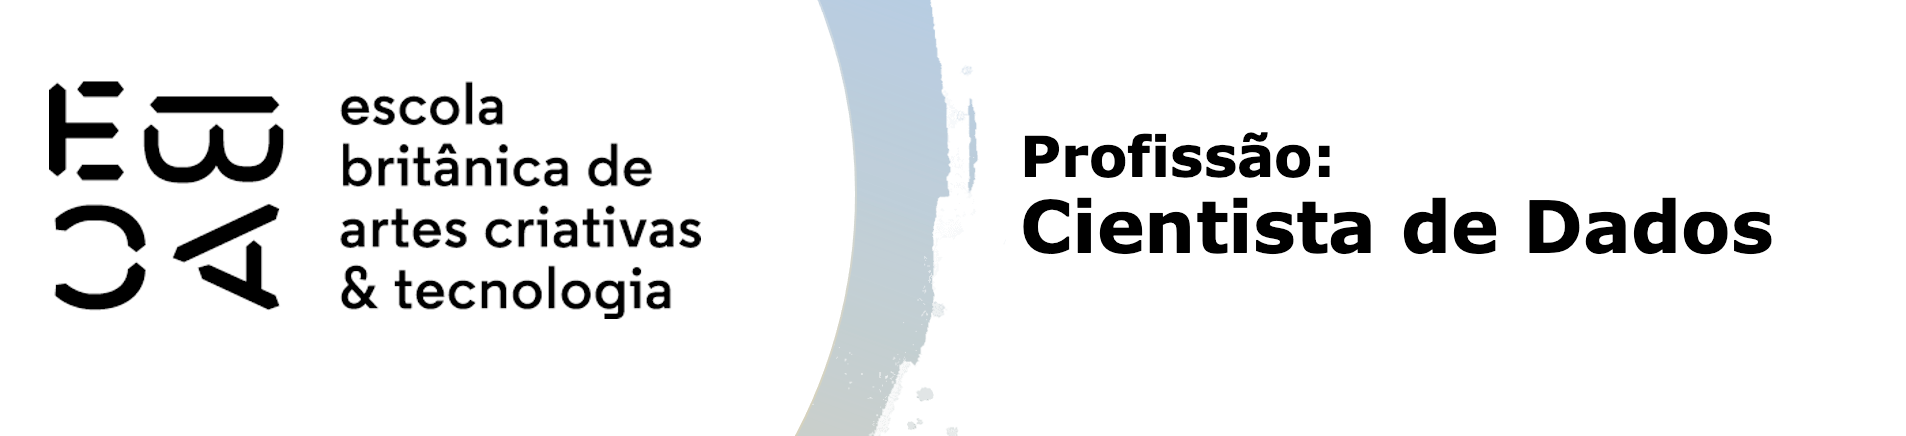

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# importando as biliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import warnings
warnings.filterwarnings('ignore')

In [2]:
# carregando a base
df = pd.read_feather('../Tarefa 01/credit_scoring.ftr')

# conferindo resultado
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
# criando um metadados que vai iniciar com um dataframe que possui os tipos de dados que temos em nosso df
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])

# conferindo quantos missings temos em cada variavel
metadados['nmissing'] = df.isna().sum()

# conferindo quantos valores diferentes temos para cada variável
metadados['valores_unicos'] = df.nunique()

# conferindo o resultado
metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [4]:
# Vamos transformar a variável resposta em um valor do tipo inteiro ('int64')
df['mau'] = df.mau.astype('int64')

# conferindo se foi realmente tranformado em inteiro
df.mau.dtypes

dtype('int64')

In [5]:
#conferindo o shape do df
df.shape

(750000, 15)

Temos muitos dados missing em nossa base na variável 'tempo_emprego'

Em contrapartida temos também muitos dados em nossa base (750.000 observações)

Poderíamos substituir os missings do 'tempo_emprego' pela média da soma dos valores da variável, mas acredito que esta pratica não será muito eficaz uma vez que pela quantidade de missings acabariamos de alguma forma criando viés nos dados.

Como queremos um modelo bem acurado, vamos optar por nos livrarmos de todos as observações que possuem missing na variável 'tempo_emprego', pois mesmo com a exclusão destas observações, teremos uma base com um bom número de observações sem missing.

In [6]:
# excluindo as linhas com missing em alguma variável
df = df.dropna()

# conferindo o novo shape
df.shape

(624043, 15)

In [7]:
# criando novamente o metadados para vermos se ainda existem missings na variável 'tempo_emprego'

# criando um metadados que vai iniciar com um dataframe que possui os tipos de dados que temos em nosso df
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])

# conferindo quantos missings temos em cada variavel
metadados['nmissing'] = df.isna().sum()

# conferindo quantos valores diferentes temos para cada variável
metadados['valores_unicos'] = df.nunique()

# conferindo o resultado
metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,13857
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


Com todas variáveis sem missing vamos em frente.

In [8]:
# dando uma olhada geral no df
df.describe()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
count,624043,624043.000000,624043.000000,624043.000000,624043.000000,624043.000000,6.240430e+05,624043.000000
mean,2015-08-01 07:22:04.772171264,8391.844415,0.512421,40.673808,7.748574,2.305795,2.581231e+04,0.077298
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02,0.000000
25%,2015-04-01 00:00:00,4249.000000,0.000000,33.000000,3.049315,2.000000,3.520500e+03,0.000000
50%,2015-08-01 00:00:00,8447.000000,0.000000,40.000000,6.046575,2.000000,8.179320e+03,0.000000
75%,2015-12-01 00:00:00,12556.000000,1.000000,48.000000,10.183562,3.000000,1.984318e+04,0.000000
max,2016-03-01 00:00:00,16649.000000,14.000000,67.000000,42.906849,15.000000,4.083986e+06,1.000000
std,NaN,4808.704361,0.779979,9.376053,6.687455,0.933682,8.633644e+04,0.267063


---

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [9]:
# precisamos saber quais são os meses que estão na nossa base
df['data_ref'].value_counts().sort_index()

data_ref
2015-01-01    41508
2015-02-01    41583
2015-03-01    41773
2015-04-01    41577
2015-05-01    41647
2015-06-01    41658
2015-07-01    41391
2015-08-01    41557
2015-09-01    41563
2015-10-01    41596
2015-11-01    41659
2015-12-01    41613
2016-01-01    41662
2016-02-01    41579
2016-03-01    41677
Name: count, dtype: int64

Acima podemos ver que os três ultimos meses são '2016-01-01', '2016-02-01', '2016-03-01'

In [10]:
# vamos criar então um df que terá os dados OOT (validação) chamado df_valid
df_valid = df[df['data_ref'].isin(['2016-01-01', '2016-02-01', '2016-03-01'])]

# vendo se o filtro funcionou conferindo os meses presentes neste novo df criado
df_valid['data_ref'].value_counts().sort_index()

data_ref
2016-01-01    41662
2016-02-01    41579
2016-03-01    41677
Name: count, dtype: int64

Agora precisamos criar nosso df de treinamento que seria o restante dos dados

In [11]:
# usando o df_valid para subtrair do df original
df_train = df[~df['data_ref'].isin(df_valid['data_ref'])]

# vendo se o filtro funcionou conferindo os meses presentes neste novo df criado
df_train['data_ref'].value_counts().sort_index()

data_ref
2015-01-01    41508
2015-02-01    41583
2015-03-01    41773
2015-04-01    41577
2015-05-01    41647
2015-06-01    41658
2015-07-01    41391
2015-08-01    41557
2015-09-01    41563
2015-10-01    41596
2015-11-01    41659
2015-12-01    41613
Name: count, dtype: int64

Filtro funcionou corretamente e agora temos a base original separada em treino e validação.

Podemos prosseguir.

---

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

---

 - Descreva a base quanto ao número de linhas, número de linhas para cada mês em data_ref.

In [12]:
# conferindo o shape do df_train
df_train.shape

(499125, 15)

<Axes: xlabel='data_ref'>

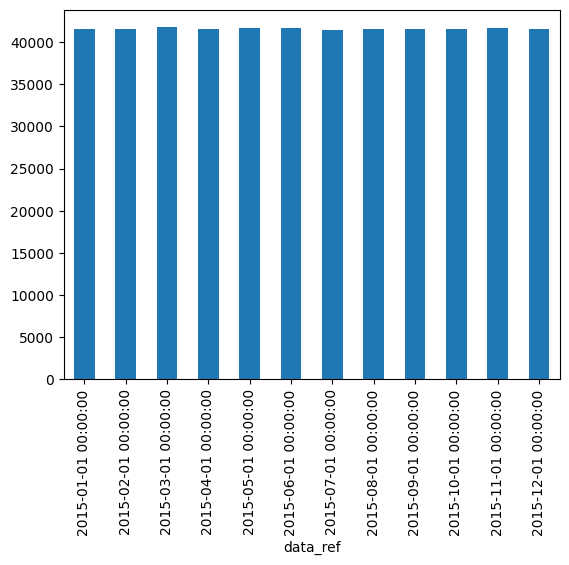

In [13]:
# criando um groupby para vermos o numero de observações para cada data em data_ref
grafico = df_train.groupby('data_ref')['data_ref'].count()

# plotando o objeto criado
grafico.plot.bar()

Temos praticamente as mesmas frequencias em todos os meses. Isso significa que a quantidade de observações é estavel durante o tempo.

---

 - Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

O objeto metadados que criamos engloba todo o df original.

Como já separamos ele em treinamento e validação, vamos criar um outro metadados para o df_train.

Desta forma nós vamos criar o metadados primeiramente.

In [14]:
# criando um metadados que vai iniciar com um dataframe que possui os tipos de dados que temos em nosso df_train
metadados1 = pd.DataFrame(df_train.dtypes, columns=['dtype'])

# conferindo quantos missings temos em cada variavel
metadados1['nmissing'] = df_train.isna().sum()

# conferindo quantos valores diferentes temos para cada variável
metadados1['valores_unicos'] = df_train.nunique()

# conferindo a saída
metadados1

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,12
index,int64,0,13857
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [15]:
# agora criando outras três colunas que vão nos passar mais algumas informações sobre as variáveis

# aqui uma coluna chamada papel com todos valores = 'covariavel'
metadados1['papel'] = 'covariavel'

# aqui localizando a variavel mau e trocando 'covariavel' por resposta na coluna 'papel'
metadados1.loc['mau','papel'] = 'resposta'

# aqui criando a variavel bom e colocando o valor 'resposta' na coluna 'papel'
metadados1.loc['bom','papel'] = 'resposta'

# conferindo resultado
metadados1

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,12.0,covariavel
index,int64,0.0,13857.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel


Abaixo vamos definir uma função que calcula o Information Value (IV)

In [16]:
# a função que calcula o information value (IV)
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

Através desta função vamos popular nosso metadados1 com os valores de IV para cada uma das variáveis.

In [17]:
# aqui um loop for para popular o metadados1 com o valor do IV para cada uma das variáveis presentes no metadados
# exceto as variaveis resposta.

for var in metadados1[metadados1.papel=='covariavel'].index:
    if  (metadados1.loc[var, 'valores_unicos']>8):
        metadados1.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados1.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

# conferindo resultado    
metadados1

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,12.0,covariavel,0.242563
index,int64,0.0,13857.0,covariavel,0.003312
sexo,object,0.0,2.0,covariavel,0.002515
posse_de_veiculo,object,0.0,2.0,covariavel,0.000036
posse_de_imovel,object,0.0,2.0,covariavel,0.011301
qtd_filhos,int64,0.0,8.0,covariavel,0.002626
tipo_renda,object,0.0,5.0,covariavel,0.011082
educacao,object,0.0,5.0,covariavel,0.003819
estado_civil,object,0.0,5.0,covariavel,0.002406
tipo_residencia,object,0.0,6.0,covariavel,0.004550


Conferindo o os IV's de cada variável vemos que uma das mais interessantes dentre as disponíveis em nossa base a variável 'tempo_emprego' é a melhor até o momento.

---

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Vamos agora fazer uma analise bivariada das variáveis disponíveis.

Vamos criar uma função que vai nos ajudar a vermos melhor sobre os dados nesta etapa.

Tal função vai levar em consideração os valores de IV que encontramos para calcular os valores de WOE para cada variável.

A função abaixo nos ajuda a entendermos variáveis discretas.

Em nossa base temos as variáveis discretas listadas abaixo:

Sexo, posse_de_veiculo, posse_de_imovel, qtde_filhos, tipo_renda, educacao, estado_civil, tipo_residencia, qt_pessoas_residencia

In [18]:
# função para plotar uma analise visual de uma bivariada discreta

def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

Vamos agora usar esta função para visualizarmos os dados em gráficos.

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,297638,19868,0.062575,F,317506,0.000430,0.063418,0.061733,-2.706768,-2.692495,-2.721220,0.037068,0.051340,0.022615
M,171322,10297,0.056696,M,181619,0.000543,0.057759,0.055632,-2.811692,-2.791978,-2.831757,-0.067857,-0.048143,-0.087922


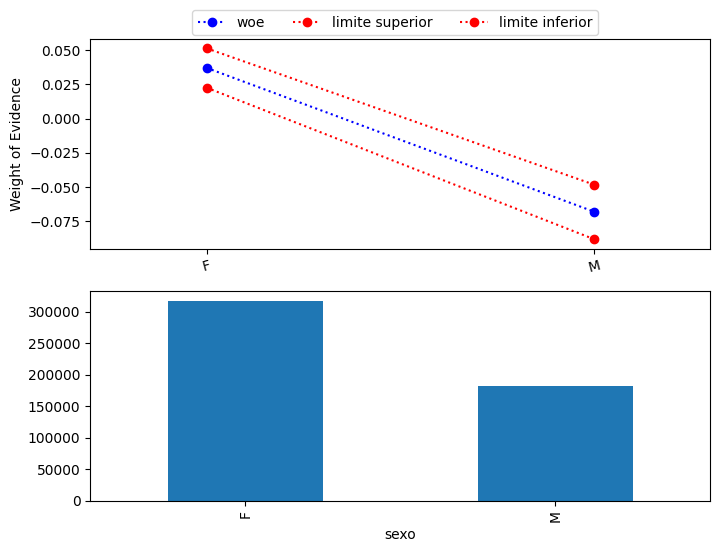

In [19]:
# variável discreta 'sexo'
biv_discreta('sexo', df_train)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,270777,17507,0.060728,N,288284,0.000445,0.06160,0.059856,-2.738695,-2.723512,-2.754083,0.005140,0.020323,-0.010248
S,198183,12658,0.060036,S,210841,0.000517,0.06105,0.059022,-2.750901,-2.733073,-2.769014,-0.007066,0.010762,-0.025178


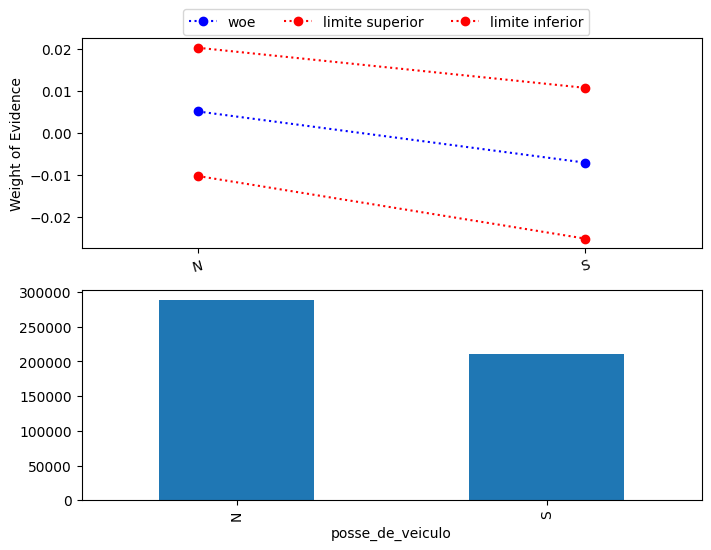

In [20]:
# variável discreta 'posse_de_veiculo'
biv_discreta('posse_de_veiculo', df_train)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,162233,11984,0.068788,N,174217,0.000606,0.069976,0.067599,-2.605461,-2.587054,-2.624165,0.138374,0.156781,0.119670
S,306727,18181,0.055957,S,324908,0.000403,0.056748,0.055167,-2.825581,-2.810719,-2.840642,-0.081746,-0.066884,-0.096807


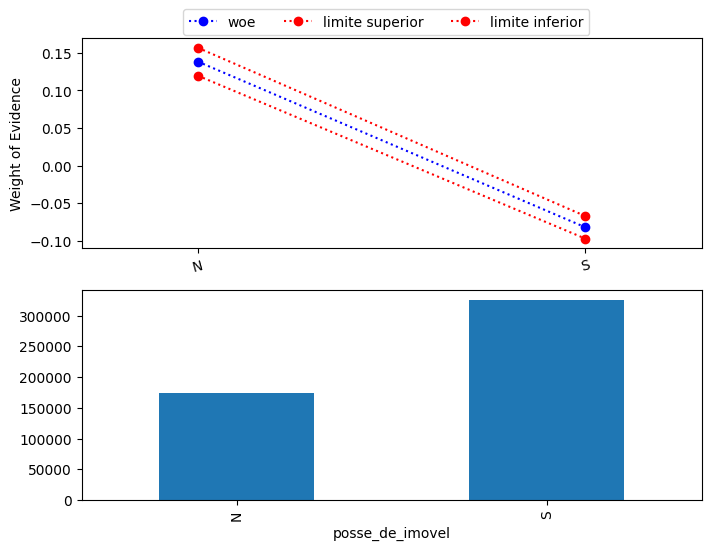

In [21]:
# variável discreta 'posse_de_imovel'
biv_discreta('posse_de_imovel', df_train)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,297831,18518,0.058537,0,316349,0.000417,0.059355,0.057719,-2.777783,-2.763035,-2.792725,-0.033948,-0.019200,-0.048890
1,112132,7734,0.064522,1,119866,0.000710,0.065913,0.063131,-2.674051,-2.651236,-2.697328,0.069785,0.092599,0.046507
2,51546,3378,0.061503,2,54924,0.001025,0.063512,0.059494,-2.725191,-2.690900,-2.760545,0.018644,0.052935,-0.016710
3,6445,457,0.066213,3,6902,0.002993,0.072080,0.060345,-2.646377,-2.555170,-2.745426,0.097459,0.188665,-0.001591
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.077048,0.182599,-0.415195
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.841728,1.395662,-0.127852
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.074678,1.584507,0.277939
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.530862,1.152198,-0.802237


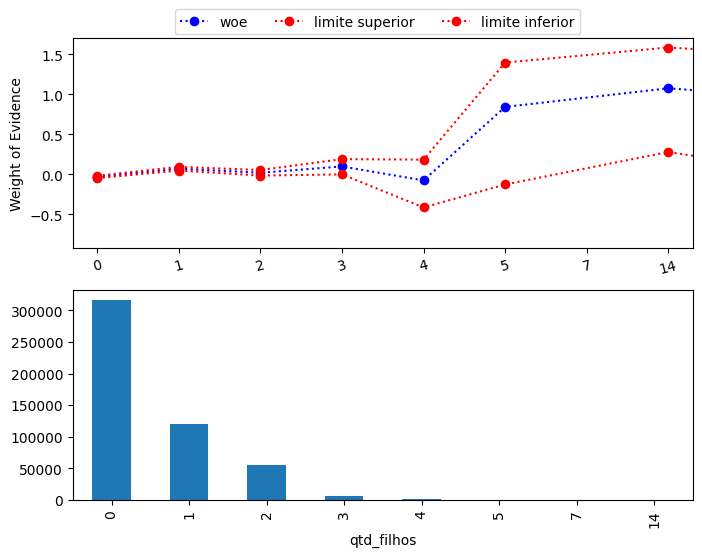

In [22]:
# variável discreta 'qtd_filhos'
biv_discreta('qtd_filhos', df_train)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.053150,0.067528,0.038589
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.402470,0.064077,-1.238781
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.018334,0.003759,-0.040865
Pensionista,230,22,0.087302,Pensionista,252,0.017782,0.122322,0.052281,-2.347037,-1.970623,-2.897422,0.396798,0.773213,-0.153587
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.315315,-0.274534,-0.357669


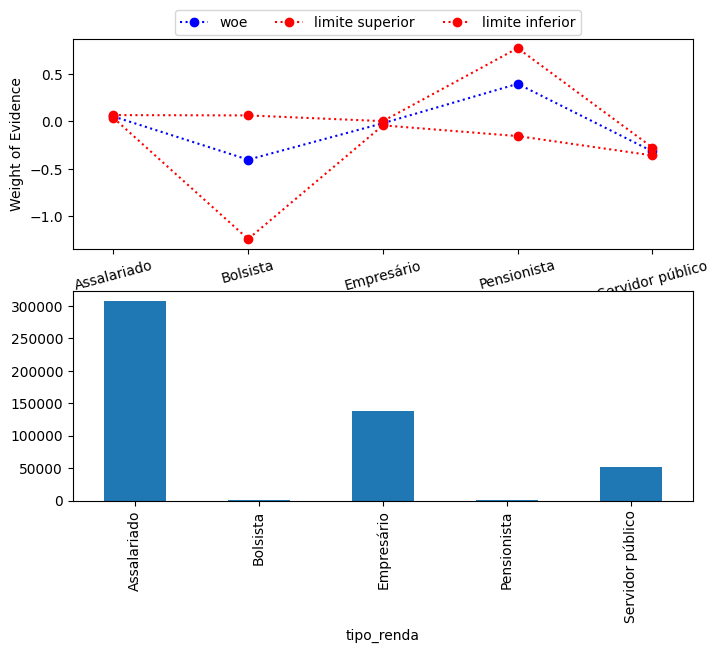

In [23]:
# variável discreta 'tipo_renda'
biv_discreta('tipo_renda', df_train)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,3665,278,0.070505,Fundamental,3943,0.004077,0.078498,0.062512,-2.578963,-2.462938,-2.707848,0.164873,0.280897,0.035987
Médio,305159,20261,0.062261,Médio,325420,0.000424,0.063091,0.061431,-2.712135,-2.698004,-2.726444,0.031700,0.045832,0.017391
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.094860,0.369709,-0.267032
Superior completo,138498,8103,0.055272,Superior completo,146601,0.000597,0.056442,0.054103,-2.838622,-2.816440,-2.861249,-0.094786,-0.072605,-0.117414
Superior incompleto,21030,1480,0.065749,Superior incompleto,22510,0.001652,0.068986,0.062511,-2.653908,-2.602364,-2.707868,0.089927,0.141471,0.035967


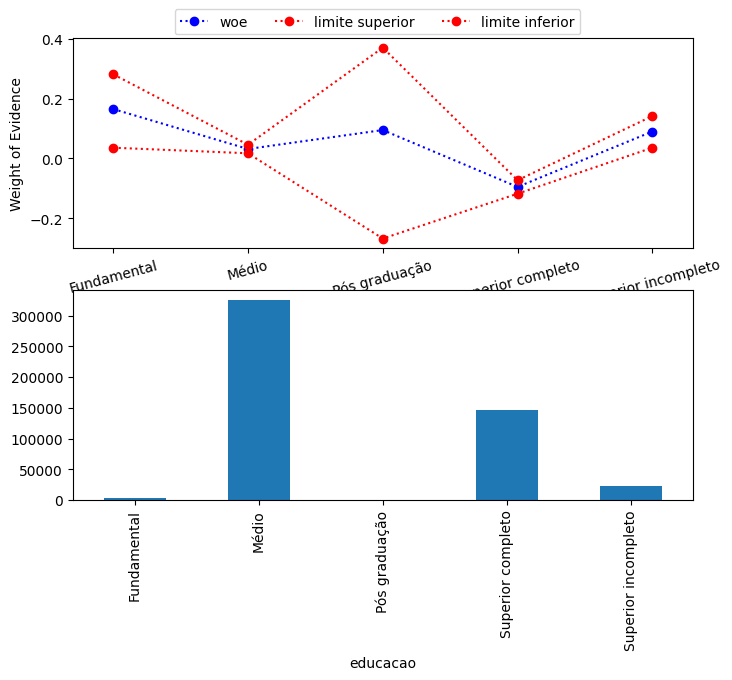

In [24]:
# variável discreta 'educacao'
biv_discreta('educacao', df_train)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,334833,21177,0.059484,Casado,356010,0.000396,0.060261,0.058707,-2.760716,-2.746913,-2.774690,-0.016881,-0.003077,-0.030855
Separado,27293,1813,0.062290,Separado,29106,0.001417,0.065066,0.059513,-2.711647,-2.665071,-2.760204,0.032188,0.078764,-0.016369
Solteiro,58354,3968,0.063669,Solteiro,62322,0.000978,0.065586,0.061752,-2.688266,-2.656552,-2.720882,0.055569,0.087283,0.022953
União,37294,2630,0.065875,União,39924,0.001241,0.068309,0.063442,-2.651849,-2.612967,-2.692089,0.091987,0.130868,0.051746
Viúvo,11186,577,0.049052,Viúvo,11763,0.001991,0.052955,0.045149,-2.964576,-2.883894,-3.051593,-0.220741,-0.140059,-0.307758


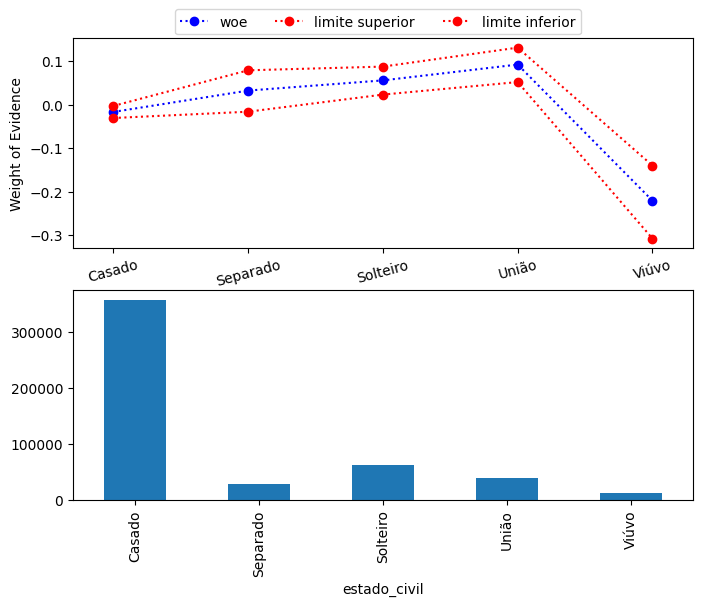

In [25]:
# variável discreta 'estado_civil'
biv_discreta('estado_civil', df_train)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7183,569,0.073400,Aluguel,7752,0.002962,0.079207,0.067594,-2.535592,-2.453174,-2.624248,0.208243,0.290662,0.119587
Casa,416221,26231,0.059286,Casa,442452,0.000355,0.059981,0.058590,-2.764274,-2.751865,-2.776821,-0.020439,-0.008030,-0.032986
Com os pais,24658,1996,0.074886,Com os pais,26654,0.001612,0.078046,0.071726,-2.513956,-2.469203,-2.560480,0.229879,0.274632,0.183355
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.160756,0.301473,0.000636
Estúdio,3590,200,0.052770,Estúdio,3790,0.003632,0.059891,0.045650,-2.887590,-2.753476,-3.040020,-0.143755,-0.009641,-0.296185
Governamental,14859,984,0.062109,Governamental,15843,0.001918,0.065868,0.058351,-2.714735,-2.651965,-2.781157,0.029100,0.091870,-0.037322


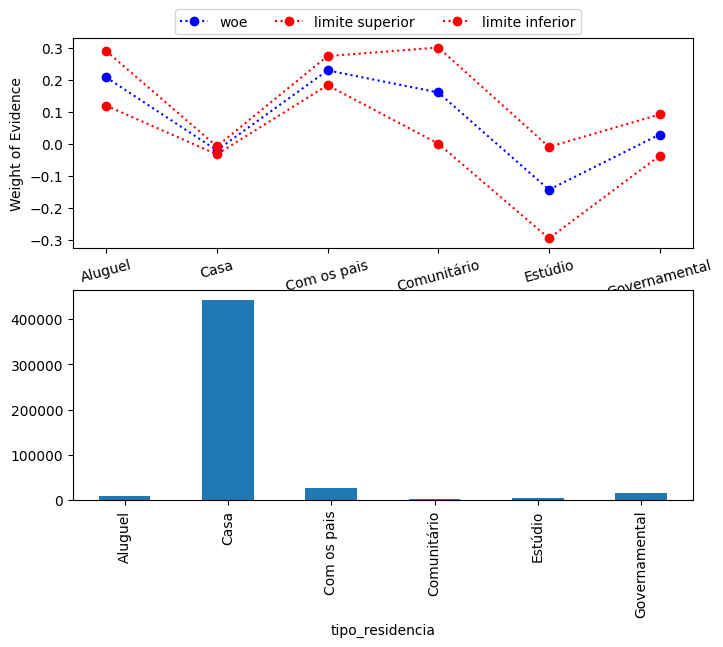

In [26]:
# variável discreta 'tipo_residencia'
biv_discreta('tipo_residencia', df_train)

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,74403,4885,0.061611,1.0,79288,0.000854,0.063285,0.059937,-2.723327,-2.694739,-2.752650,0.020508,0.049096,-0.008815
2.0,243087,14930,0.057864,2.0,258017,0.000460,0.058765,0.056963,-2.790047,-2.773640,-2.806695,-0.046212,-0.029805,-0.062859
3.0,94882,6612,0.065147,3.0,101494,0.000775,0.066665,0.063628,-2.663748,-2.639084,-2.688952,0.080087,0.104751,0.054883
4.0,49393,3211,0.061041,4.0,52604,0.001044,0.063087,0.058995,-2.733226,-2.698078,-2.769494,0.010609,0.045757,-0.025659
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.120329,0.212394,0.020295
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.080446,0.320446,-0.223349
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.074678,1.584507,0.277939
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.530862,1.152198,-0.802237


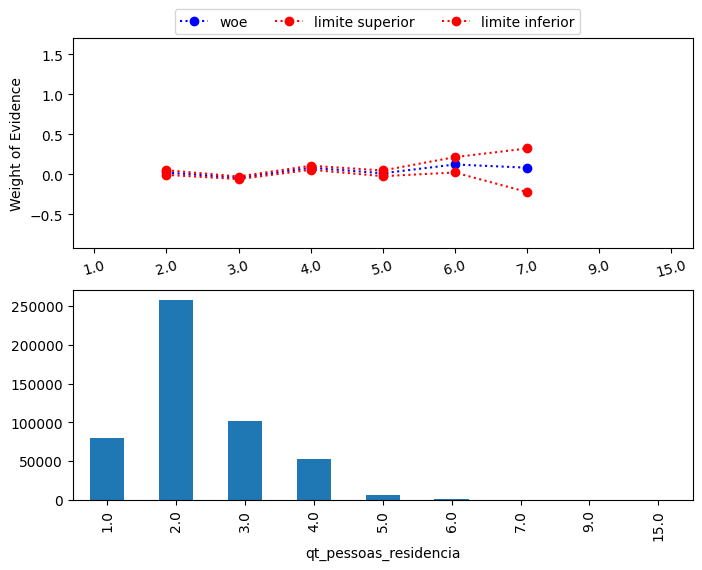

In [27]:
# variável discreta 'qt_pessoas_residencia'
biv_discreta('qt_pessoas_residencia', df_train)

Agora vamos criar abaixo uma função que vai fazer o mesmo acima só que com variaveis contínuas.

As variáveis contínuas em nossa base são as lsitadas abaixo:

idade, tempo_emprego, renda

In [28]:
# agora criando uma função para bivariadas de variaveis continuas

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

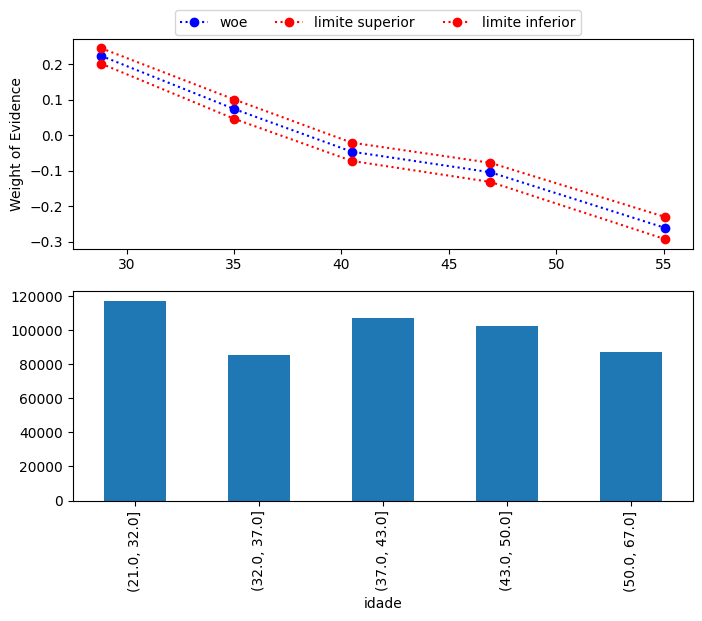

In [29]:
# variável continua 'idade'
biv_continua('idade', 5, df_train)

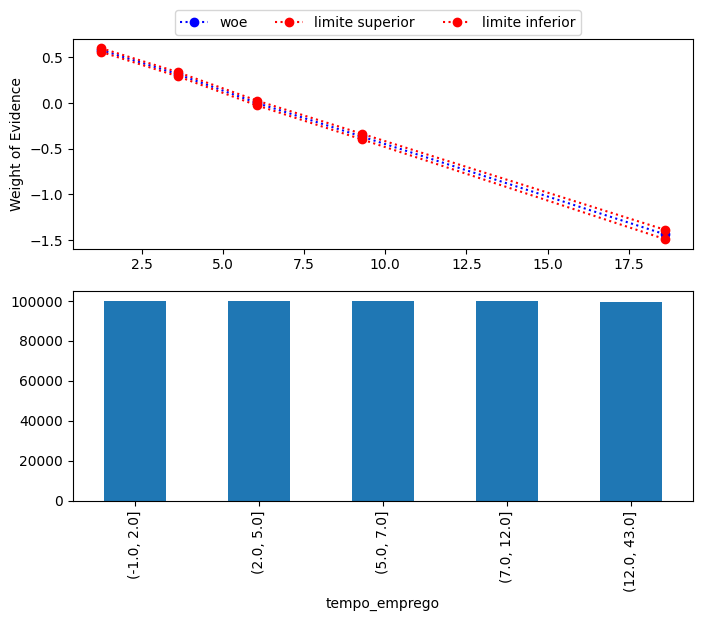

In [30]:
# variável continua 'tempo_emprego'
biv_continua('tempo_emprego', 5, df_train)

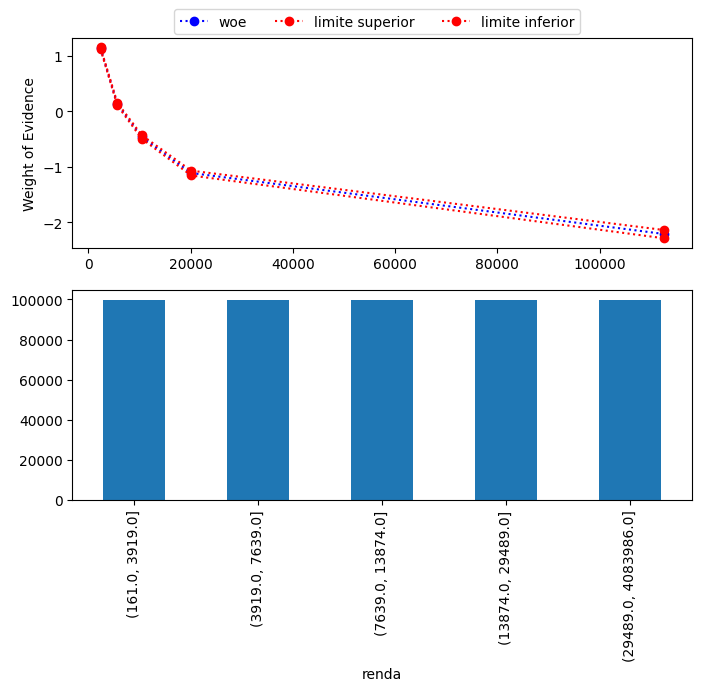

In [31]:
# variável continua 'renda'
biv_continua('renda', 5, df_train)

---

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

---

 - Trate valores missings e outliers

Os valores missings foram tratados anteriormente conforme podemos ver no metadados1

In [32]:
metadados1

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,12.0,covariavel,0.242563
index,int64,0.0,13857.0,covariavel,0.003312
sexo,object,0.0,2.0,covariavel,0.002515
posse_de_veiculo,object,0.0,2.0,covariavel,0.000036
posse_de_imovel,object,0.0,2.0,covariavel,0.011301
qtd_filhos,int64,0.0,8.0,covariavel,0.002626
tipo_renda,object,0.0,5.0,covariavel,0.011082
educacao,object,0.0,5.0,covariavel,0.003819
estado_civil,object,0.0,5.0,covariavel,0.002406
tipo_residencia,object,0.0,6.0,covariavel,0.004550


Quanto aos outliers vamos verificar agora.

Os outliers costumam estar presentes em variáveis contínuas. Vamos nos concentrar nelas para vermos se conseguimos identificar algum outlier.

Text(0, 0.5, 'Idade')

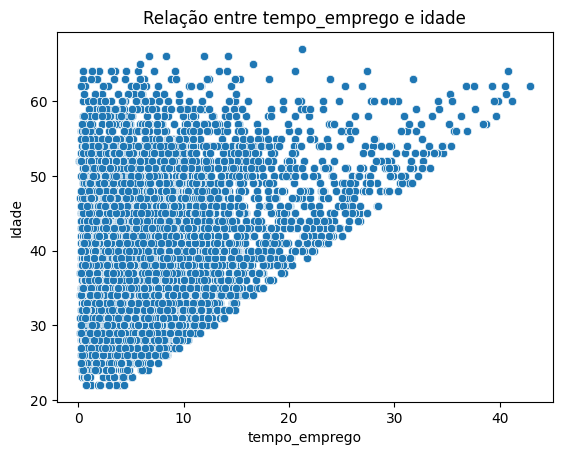

In [33]:
# criando um scatterplot pra vermos se encontramos outliers na variável 'idade' X 'tempo_emprego'

# scatterplot para verificarmos o grafico desta analise bivariada e vermos se tem observações muito fora da curva
sns.scatterplot(x='tempo_emprego', y='idade', data=df_train)

# adicionando título e rótulos
plt.title('Relação entre tempo_emprego e idade')
plt.xlabel('tempo_emprego')
plt.ylabel('Idade')

Vemos que temos uma certa simetria e relação entre aas variáveis.

---

Text(0, 0.5, 'renda')

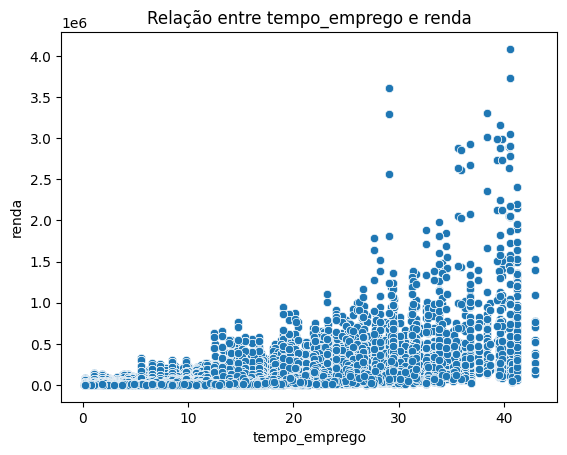

In [34]:
# criando um scatterplot pra vermos se encontramos outliers na variável 'renda' X 'tempo_emprego'

# scatterplot para verificarmos o grafico desta analise bivariada e vermos se tem observações muito fora da curva
sns.scatterplot(x='tempo_emprego', y='renda', data=df_train)

# Adicionar título e rótulos
plt.title('Relação entre tempo_emprego e renda')
plt.xlabel('tempo_emprego')
plt.ylabel('renda')

Aqui já podemos ver que temos algumas observações fugindo da curva.

Vamos considerar como outliers todas as observações que temos cujo a renda ultrapassa 2400000.00.

Nesta altura existem muitos pontos soltos no grafico e com a retirada deles, teremos um grafico com pontos mais obdientes a um certo padrão.

<Axes: xlabel='tempo_emprego', ylabel='renda'>

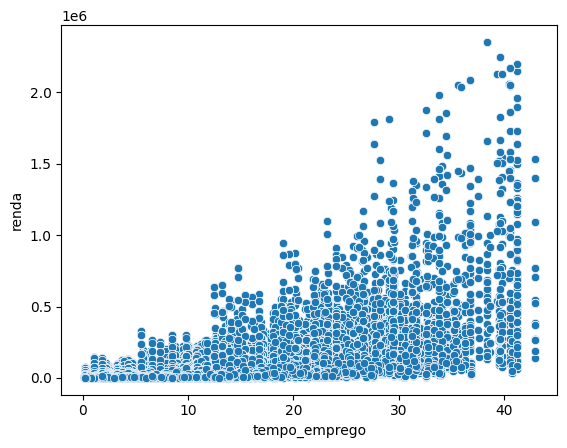

In [35]:
# para teste vamos criar um objeto que vai fltrar as observações com renda menor que 2400000 de forma que os pontos
# fora da curva estejam ausentes no gráfico
filtro = df_train[df_train['renda']<=2400000]

# testando o scatterplot com estes dados filtrados
sns.scatterplot(x='tempo_emprego', y='renda', data=filtro)

Aqui já podemos ver que temos um grafico com pontos que se correlacionam melhor.

Sendo assim vamos adotar a ideia de elimiar estas observações do gráfico.

In [36]:
# filtrando o df_train para eliminarmos os outliers
df_train = df_train[df_train['renda']<=2400000]

# conferindo agora qual é o maior valor que temos no grafico
df_train.renda.max()

2352100.07

<Axes: xlabel='tempo_emprego', ylabel='renda'>

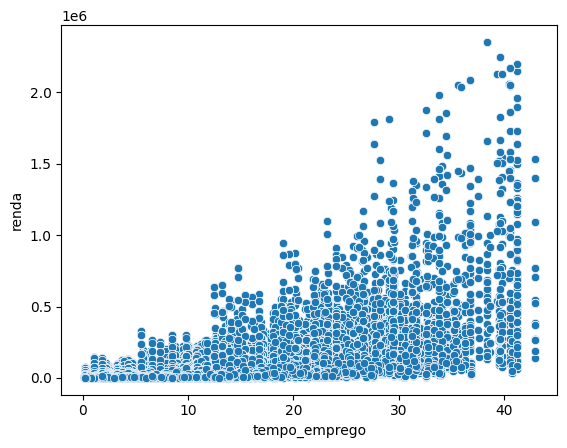

In [37]:
# testando o scatterplot com este novo df
sns.scatterplot(x='tempo_emprego', y='renda', data=df_train)

In [38]:
# conferindo o novo shape do nosso df_train sem os pontos que consideramos como outliers
df_train.shape

(499005, 16)

Antes tinhamos 499125 observações.

Perdemos poucas observações e conseguimos melhorar um pouco a homogenização do relacionamento entre nossos dados.

---

 - Trate 'zeros estruturais'

Quanto aos zeros estruturais, vimos que em todos graficos que plotamos na analise bivariada não tivemos erros em nenhum dos graficos para nenhuma das catagorias de cada variável.

Sendo assim podemos concluir de que não existem ZEROS estruturais em nossa base para serem tratados.

Vamos observar a tabela populada com o WOE para ilustramos esta dúvida.

Para isso vamos rodar a rotina da construção do metadados novamente, pois o shape do df_train mudou com a remoção dos outliers e isso pode influenciar de certo modo nos valores apresentados anteriormente na tabela metadados1:

In [39]:
# recriando o metadados que vai iniciar com um dataframe que possui os tipos de dados que temos em nosso df_train
metadados1 = pd.DataFrame(df_train.dtypes, columns=['dtype'])

# conferindo quantos missings temos em cada variavel
metadados1['nmissing'] = df_train.isna().sum()

# conferindo quantos valores diferentes temos para cada variável
metadados1['valores_unicos'] = df_train.nunique()

# aqui uma coluna chamada papel com todos valores = 'covariavel'
metadados1['papel'] = 'covariavel'

# aqui localizando a variavel mau e trocando 'covariavel' por resposta na coluna 'papel'
metadados1.loc['mau','papel'] = 'resposta'

# aqui criando a variavel bom e colocando o valor 'resposta' na coluna 'papel'
metadados1.loc['bom','papel'] = 'resposta'

# conferindo resultado
metadados1

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,12,covariavel
index,int64,0,13857,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel


In [40]:
# a função que calcula o information value (IV)
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [41]:
# aqui um loop for para popular o metadados1 com o valor do IV para cada uma das variáveis presentes no metadados
# exceto as variaveis resposta.

for var in metadados1[metadados1.papel=='covariavel'].index:
    if  (metadados1.loc[var, 'valores_unicos']>8):
        metadados1.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados1.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

# conferindo resultado    
metadados1

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,12,covariavel,0.242282
index,int64,0,13857,covariavel,0.003316
sexo,object,0,2,covariavel,0.002534
posse_de_veiculo,object,0,2,covariavel,0.000039
posse_de_imovel,object,0,2,covariavel,0.011269
qtd_filhos,int64,0,8,covariavel,0.002612
tipo_renda,object,0,5,covariavel,0.011086
educacao,object,0,5,covariavel,0.003813
estado_civil,object,0,5,covariavel,0.002408
tipo_residencia,object,0,6,covariavel,0.004540


In [42]:
df_train.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0,1
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0,1
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0,1
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0,1
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0,1


In [43]:
# agora populando com os valores de WOE

# para cada variavel no index do metadaos 1
for var in metadados1.index:
    #se o numero de categorias da variavel tem mais de 6 categorias:
    if df_train[var].nunique()>6:
        # crie uma tabela com crosstab entre a variavel reunida em 5 grupos e a variavel mau
        tab = pd.crosstab(pd.qcut(df_train[var], 5, duplicates='drop'), df_train['mau'], margins=True, margins_name='total')
        
        # nomeie a coluna com valor 0 como não evento
        rotulo_nao_evento = tab.columns[0]
         # nomeie a coluna com valor 1 como evento
        rotulo_evento = tab.columns[1]

        # crie uma coluna no tab para calcular o percentual de evento
        tab['pct_evento'] = tab[rotulo_evento]/tab.loc['total',rotulo_evento]
         # crie uma coluna no tab para calcular o percentual de não evento    
        tab['pct_nao_evento'] = tab[rotulo_nao_evento]/tab.loc['total',rotulo_nao_evento]

        # calcule o WOE parcial que é o log da razaão entre os percentuais
        tab['woe_parcial'] = np.log(tab.pct_evento/tab.pct_nao_evento)

        # some todos os valores de woe parcial da variavel
        woe_total = tab['woe_parcial'].sum()

        # inclua este valor numa nova coluna do metadados 1 chamada WOE para a variavel em questão
        metadados1.loc[var, 'woe'] = woe_total
        
        
    #senão, se o numero de categorias da variavel tiver até 5 categorias:
    else:
        # crie uma tabela com crosstab entre a variavel do loop e a variavel mau
        tab = pd.crosstab(df_train.var, df_train.mau, margins=True, margins_name = 'total')
        
        # nomeie a coluna com valor 0 como não evento
        rotulo_nao_evento = tab.columns[0]
         # nomeie a coluna com valor 1 como evento
        rotulo_evento = tab.columns[1]

        # crie uma coluna no tab para calcular o percentual de evento
        tab['pct_evento'] = tab[rotulo_evento]/tab.loc['total',rotulo_evento]
         # crie uma coluna no tab para calcular o percentual de não evento    
        tab['pct_nao_evento'] = tab[rotulo_nao_evento]/tab.loc['total',rotulo_nao_evento]

        # calcule o WOE parcial que é o log da razaão entre os percentuais
        tab['woe_parcial'] = np.log(tab.pct_evento/tab.pct_nao_evento)

        # some todos os valores de woe parcial da variavel
        woe_total = tab['woe_parcial'].sum()

        # inclua este valor numa nova coluna do metadados 1 chamada WOE para a variavel em questão
        metadados1.loc[var, 'woe'] = woe_total

In [44]:
# conferindo nosso metadados1 que agora possui os valores de WOE para cada variável
metadados1

,dtype,nmissing,valores_unicos,papel,IV,woe
data_ref,datetime64[ns],0,12,covariavel,0.242282,-0.533632
index,int64,0,13857,covariavel,0.003316,-0.007231
sexo,object,0,2,covariavel,0.002534,0.000000
posse_de_veiculo,object,0,2,covariavel,0.000039,0.000000
posse_de_imovel,object,0,2,covariavel,0.011269,0.000000
qtd_filhos,int64,0,8,covariavel,0.002612,0.025944
tipo_renda,object,0,5,covariavel,0.011086,0.000000
educacao,object,0,5,covariavel,0.003813,0.000000
estado_civil,object,0,5,covariavel,0.002408,0.000000
tipo_residencia,object,0,6,covariavel,0.004540,0.000000


---

 - Faça agrupamentos de categorias conforme vimos em aula.

In [45]:
# primeiro vamos criar um df secundário devrivado do df_train atual
df_train2 = df_train.copy()

In [46]:
# conferindo o resultado
df_train2.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,bom
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0,1
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0,1
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0,1
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0,1
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0,1


Dentre os gráficos que vimos acima na analise bivariada, vamos agrupar algumas categorias de certas variáveis.

Serão elas, as variáveis: qtde_filhos, tipo_renda, educacao e tipo_residencia.

Estes agrupamentos serão feitos com base nos valores de WOE semelhantes pois assim o grupo possuirá o mesmo peso para a variavel resposta 'mau'

In [47]:
# vamos agrupar a variável qtd_filhos com os valores de 0 até 2
df_train2.qtd_filhos.replace({0 : '0 a 2',
                              1: '0 a 2',
                              2: '0 a 2'}, inplace=True)

# conferindo se conseguimos agrupar
df_train2.qtd_filhos.unique()

array(['0 a 2', 3, 4, 7, 14, 5], dtype=object)

In [48]:
# vamos agrupar a variável tipo_renda com os valores Assalariado e Empresario
df_train2.tipo_renda.replace({'Assalariado' : 'Ass./Empres','Empresário': 'Ass./Empres'}, inplace=True)

# conferindo se conseguimos agrupar
df_train2.tipo_renda.unique()

array(['Ass./Empres', 'Servidor público', 'Bolsista', 'Pensionista'],
      dtype=object)

In [49]:
# vamos fazer dois grupos com a variável educacao com os valores Fundamental e Médio  e depois Superior completo e superior incompleto
df_train2.educacao.replace({'Fundamental' : 'Fund./Méd',
                              'Médio': 'Fund./Méd',
                               'Superior incompleto': 'Sup. Compl./Incompl.',
                               'Superior completo': 'Sup. Compl./Incompl.'}, inplace=True)

# conferindo se conseguimos agrupar
df_train2.educacao.unique()

array(['Fund./Méd', 'Sup. Compl./Incompl.', 'Pós graduação'], dtype=object)

---

 - Proponha uma equação preditiva para 'mau'

Vamos visuzalizar antes de mais nada quais são as variáveis que temos na base atualmente para df_train2:

In [50]:
# ajuda para definir a equação da regressão
' + '.join(list(df_train2.columns))

'data_ref + index + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [51]:
# descrevendo a formula do statsmodels para passar para o objeto de regressão logistica que vamos criar agora
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel +  qtd_filhos + 
    tipo_renda + educacao + estado_civil + tipo_residencia + idade +
    tempo_emprego + qt_pessoas_residencia + renda
'''

# regressão rl pediu ( a formula acima e a base de dados )
# usamos glm ao invés de ols pois o glm pode lidar com variaveis de resposta que não seguem uma distribuição normal,
# permitindo uma maior flexibilidade para dados categóricos, contagens e outras formas.
# o familly = sm.families.Binomial significa que a variavel resposta é uma variavel binomial
# por ultimo aplicando o fit() para treinar o modelo com os dados.
rl = smf.glm(formula, data=df_train2, family=sm.families.Binomial()).fit()

# conferindo o sumario da regressão feita
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499005
Model:                            GLM   Df Residuals:                   498978
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0248e+05
Date:                Thu, 17 Oct 2024   Deviance:                   2.0485e+05
Time:                        18:32:29   Pearson chi2:                 1.42e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04466
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.3017      0.090    -14.432      0.000      -1.479      -1.125
sexo[T.M]                           -0.1435      0.014    -10.413      0.000      -0.170      -0.116
posse_de_veiculo[T.S]                0.0283      0.013      2.130      0.033       0.002       0.054
posse_de_imovel[T.S]                -0.1008      0.013     -7.845      0.000      -0.126      -0.076
qtd_filhos[T.4]                     -0.1975      0.160     -1.238      0.216      -0.510       0.115
qtd_filhos[T.5]                      0.5551      0.367      1.514      0.130      -0.163       1.274
qtd_filhos[T.7]                      0.2086      0.310      0.674      0.500      -0.398       0.816
qtd_filhos[T.14]                     0.2294      0.421      0.544      0.586      -0.596       1.055
qtd_filhos[T.0 a 2]                 -0.0837      0.055     -1.530      0.126      -0.191       0.024
tipo_renda[T.Bolsista]               0.1441      0.300      0.480      0.631      -0.444       0.732
tipo_renda[T.Pensionista]            0.0582      0.226      0.257      0.797      -0.385       0.502
tipo_renda[T.Servidor público]      -0.0152      0.023     -0.667      0.504      -0.060       0.030
educacao[T.Pós graduação]           -0.0322      0.161     -0.201      0.841      -0.347       0.283
educacao[T.Sup. Compl./Incompl.]    -0.0754      0.013     -5.590      0.000      -0.102      -0.049
estado_civil[T.Separado]             0.0165      0.028      0.587      0.557      -0.039       0.072
estado_civil[T.Solteiro]             0.0019      0.023      0.082      0.935      -0.043       0.047
estado_civil[T.União]                0.0313      0.022      1.423      0.155      -0.012       0.074
estado_civil[T.Viúvo]               -0.1284      0.046     -2.775      0.006      -0.219      -0.038
tipo_residencia[T.Casa]             -0.0942      0.045     -2.088      0.037      -0.183      -0.006
tipo_residencia[T.Com os pais]      -0.0802      0.050     -1.589      0.112      -0.179       0.019
tipo_residencia[T.Comunitário]      -0.1216      0.090     -1.355      0.175      -0.297       0.054
tipo_residencia[T.Estúdio]          -0.0337      0.087     -0.390      0.697      -0.203       0.136
tipo_residencia[T.Governamental]    -0.0895      0.056     -1.601      0.109      -0.199       0.020
idade                               -0.0001      0.001     -0.190      0.850      -0.002       0.001
tempo_emprego                       -0.0257      0.002    -14.065      0.000      -0.029      -0.022
qt_pessoas_residencia               -0.0053      0.009     -0.565      0.572      -0.024       0.013
renda                            -9.767e-05   1.18e-06    -83.113      0.000     -0.0001   -9.54e-05
=====================================================

---

 - Caso hajam categorias não significantes, justifique

Poucas variaveis apresentaram significancia estatistica depois de rodar a regressão com todas variáveis disponíveis na base.

Vamos dar uma olhada no ranking dos informations values para cada variavel da base.

In [52]:
# recriando o metadados que vai iniciar com um dataframe que possui os tipos de dados que temos em nosso df_train depois que fizemos o agrupamento
metadados1 = pd.DataFrame(df_train.dtypes, columns=['dtype'])

# conferindo quantos missings temos em cada variavel
metadados1['nmissing'] = df_train.isna().sum()

# conferindo quantos valores diferentes temos para cada variável
metadados1['valores_unicos'] = df_train.nunique()

# aqui uma coluna chamada papel com todos valores = 'covariavel'
metadados1['papel'] = 'covariavel'

# aqui localizando a variavel mau e trocando 'covariavel' por resposta na coluna 'papel'
metadados1.loc['mau','papel'] = 'resposta'

# aqui criando a variavel bom e colocando o valor 'resposta' na coluna 'papel'
metadados1.loc['bom','papel'] = 'resposta'

# a função que calcula o information value (IV)
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

# aqui um loop for para popular o metadados1 com o valor do IV para cada uma das variáveis presentes no metadados
# exceto as variaveis resposta.

for var in metadados1[metadados1.papel=='covariavel'].index:
    if  (metadados1.loc[var, 'valores_unicos']>8):
        metadados1.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados1.loc[var, 'IV'] = IV(df_train[var], df_train.mau)


# conferindo metadados1
metadados1

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,12,covariavel,0.242282
index,int64,0,13857,covariavel,0.003316
sexo,object,0,2,covariavel,0.002534
posse_de_veiculo,object,0,2,covariavel,0.000039
posse_de_imovel,object,0,2,covariavel,0.011269
qtd_filhos,int64,0,8,covariavel,0.002612
tipo_renda,object,0,5,covariavel,0.011086
educacao,object,0,5,covariavel,0.003813
estado_civil,object,0,5,covariavel,0.002408
tipo_residencia,object,0,6,covariavel,0.004540


In [53]:
# usando o truque de obtermos os nomes das variaveis de forma mais facil
' + '.join(list(metadados1.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + data_ref + idade + posse_de_imovel + tipo_renda + tipo_residencia + educacao + index + qtd_filhos + sexo + estado_civil + qt_pessoas_residencia + posse_de_veiculo + mau + bom'

In [54]:
# aplicando o sort_values por IV do maior para o menor
metadados1.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0,93869,covariavel,1.033317
tempo_emprego,float64,0,3004,covariavel,0.359381
data_ref,datetime64[ns],0,12,covariavel,0.242282
idade,int64,0,46,covariavel,0.027001
posse_de_imovel,object,0,2,covariavel,0.011269
tipo_renda,object,0,5,covariavel,0.011086
tipo_residencia,object,0,6,covariavel,0.004540
educacao,object,0,5,covariavel,0.003813
index,int64,0,13857,covariavel,0.003316
qtd_filhos,int64,0,8,covariavel,0.002612


Conforme observado an tabela acima, nós vamos selecionar somente as variáveis cujo o valor de IV é igual ou maior que 0.01.

Ficamos então com as variáveis selecionadas que são: renda, tempo_emprego, idade, posse_de_imovel e tipo_renda.

A variável data_ref não vai entrar na regressão.

In [55]:
# criando a variavel formula novamente para descrever as variaveis 
# que queremos desta vez que serão somente as que tiveram um IV maior que 0.01 
formula = 'mau ~ renda + tempo_emprego + idade + posse_de_imovel + tipo_renda'

In [56]:
# rodando nova regressão com o glm
rl2 = smf.glm(formula, data=df_train2, family=sm.families.Binomial()).fit()

# vizualizando o sumário
rl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499005
Model:                            GLM   Df Residuals:                   498997
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0255e+05
Date:                Thu, 17 Oct 2024   Deviance:                   2.0500e+05
Time:                        18:32:50   Pearson chi2:                 1.46e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04436
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.5885      0.028    -57.676      0.000      -1.643      -1.535
posse_de_imovel[T.S]              -0.0967      0.013     -7.739      0.000      -0.121      -0.072
tipo_renda[T.Bolsista]             0.1132      0.300      0.378      0.706      -0.474       0.700
tipo_renda[T.Pensionista]          0.0276      0.226      0.122      0.903      -0.415       0.471
tipo_renda[T.Servidor público]    -0.0244      0.023     -1.075      0.283      -0.069       0.020
renda                          -9.911e-05   1.17e-06    -84.469      0.000      -0.000   -9.68e-05
tempo_emprego                     -0.0248      0.002    -13.738      0.000      -0.028      -0.021
idade                              0.0009      0.001      1.407      0.159      -0.000       0.002
==================================================================================================
"""

Segundo os valores de p-value a variável tipo_renda ainda não se provou estatisticamente importante para a modelagem.

Vamos retirar também.

In [57]:
# criando a variavel formula novamente para descrever as variaveis 
# que queremos desta vez que serão somente as que tiveram um IV maior que 0.01 
formula = 'mau ~ renda + tempo_emprego + idade + posse_de_imovel'

# rodando nova regressão com o glm
rl3 = smf.glm(formula, data=df_train2, family=sm.families.Binomial()).fit()

# vizualizando o sumário
rl3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499005
Model:                            GLM   Df Residuals:                   499000
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0255e+05
Date:                Thu, 17 Oct 2024   Deviance:                   2.0500e+05
Time:                        18:32:55   Pearson chi2:                 1.46e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04436
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.5901      0.028    -57.817      0.000      -1.644      -1.536
posse_de_imovel[T.S]    -0.0967      0.012     -7.737      0.000      -0.121      -0.072
renda                -9.913e-05   1.17e-06    -84.494      0.000      -0.000   -9.68e-05
tempo_emprego           -0.0250      0.002    -13.883      0.000      -0.029      -0.021
idade                    0.0009      0.001      1.429      0.153      -0.000       0.002
========================================================================================
"""

Acima vemos que a variável idade não se mostrou muito relevante estatisticamente segundo seu p-value.

Porém achamos importante mantê-la pois pode ser uma informação importante para a insituição quanto a longevidade do individuo caso ele seja elegivel a obter credito com a instituição.

---

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

Como nosso df_train2 sofreu algumas mudanças em sua estrutura e informações, teremos que fazer o mesmo para df_valid a fim de que ele contenha a mesma estrutura e informações pertinentes.

Para isso, vamos recordar que fizemos agrupamentos em algumas variáveis na fase de analise bivariada. Realizamos mudanças nas informações das variáveis: 'qtd_filhos', 'tipo_renda', 'educacao' e 'tipo_residencia'.

Contudo, para a modelagem do objeto de regressão logística, acabamos escolhendo as seguintes variáveis: 'renda', 'tempo_emprego', 'idade' e 'posse_de_imovel'.

Há de se pensar que nenhuma das variaveis usadas para construir a regressão sofreu mudanças e logo não precisaremos fazer tais mudanças no dataframe.

Mas será que isso é verdade?

Ao meu ver acredito que sim, pois ao desenhar a regressão logistica sem as variaveis que modificamos os valores, não estamos sendo afetados em nada pois é como se elas não existissem para os calculos.

Sendo assim, vamos realizar a avaliação do modelo.

In [58]:
# dropando a coluna 'bom' do df_train2
df_train2.drop(columns = 'bom',inplace=True)

# conferindo resultado
df_train2.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0 a 2,Ass./Empres,Fund./Méd,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0 a 2,Ass./Empres,Fund./Méd,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,0 a 2,Ass./Empres,Fund./Méd,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0 a 2,Ass./Empres,Fund./Méd,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0 a 2,Ass./Empres,Sup. Compl./Incompl.,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [59]:
# criando a base explicativa para o df_valid (base explicativa é o df_valid original sem a variavel resposta 'mau')
df_valid_X = df_valid.drop(columns = 'mau')

# conferindo o resultado
df_valid_X.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19


In [60]:
# criando a base de resposta para o df_valid (base da target é  a coluna 'mau' do df_valid original)
df_valid_y = df_valid['mau']

# conferindo o resultado
df_valid_y

600000    1
600001    0
600002    0
600003    0
600004    0
         ..
749993    0
749995    0
749997    1
749998    1
749999    0
Name: mau, Length: 124918, dtype: int64

In [61]:
# esta celula agora tem o intuito de sabermos os parâmetros do modelo da regressão logistica que fizemos.

#criando nova coluna no df2 que possui as categorias tratadas
df_valid['predict'] = rl3.predict(df_valid_X)

# Convertendo probabilidades em classificações binárias usando um limiar de 0.5
df_valid['predicted_class'] = (df_valid['predict'] > 0.5).astype(int)

# Calculando a acurácia
acc = metrics.accuracy_score(df_valid_y, df_valid['predicted_class'])

# conferindo resultado
acc

0.8553290958869018

---

## Criar um pipeline utilizando o sklearn pipeline 

In [62]:
# carregando algumas bibliotecas do sklearn
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

---

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [63]:
# Classe para substituir valores nulos
from sklearn.base import BaseEstimator, TransformerMixin

class SubstituiNans(BaseEstimator, TransformerMixin):
    def __init__(self, metodo='mean'):
        self.metodo = metodo

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.select_dtypes(include=['float64', 'int64']).columns:
            if X[column].isnull().any():
                if self.metodo == 'mean':
                    mean_value = X[column].mean()
                    X[column].fillna(mean_value, inplace=True)
        return X

---

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [64]:
# definindo função para remover outliers do nosso df considerando o Intervalo Interquartil = 1.7

# Classe para remover outliers
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, valor_iqr=1.7):
        self.valor_iqr = valor_iqr

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in X.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - self.valor_iqr * IQR
            limite_superior = Q3 + self.valor_iqr * IQR
            X = X[(X[column] >= limite_inferior) & (X[column] <= limite_superior)]
        return X

---

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [65]:
# carregando uma biblioteca que vai ser preciso para criação da função
from sklearn.base import BaseEstimator, TransformerMixin


# Função para calcular o IV de uma variável
def calculate_iv(df, feature, target):
    lst = []
    
    # Calcular a distribuição dos bons (target=0) e maus (target=1)
    for i in range(df[feature].nunique()):
        val = df[feature].unique()[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 0)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 1)].count()[feature]
        })
    
    iv_df = pd.DataFrame(lst)
    iv_df['Distr_Good'] = iv_df['Good'] / iv_df['Good'].sum()
    iv_df['Distr_Bad'] = iv_df['Bad'] / iv_df['Bad'].sum()
    
    # Calcular IV por bin
    iv_df['IV'] = (iv_df['Distr_Good'] - iv_df['Distr_Bad']) * np.log(iv_df['Distr_Good'] / iv_df['Distr_Bad'])
    iv = iv_df['IV'].sum()
    
    return iv




# Função para selecionar variáveis com base no IV
class FeatureSelectionIV(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.02):
        self.threshold = threshold
        self.iv_values = {}
    
    def fit(self, X, y):
        # Calcula o IV para cada variável independente
        for col in X.columns:
            self.iv_values[col] = calculate_iv(pd.concat([X, y], axis=1), col, y.name)
        return self
    
    def transform(self, X):
        # Seleciona apenas as variáveis com IV maior ou igual ao threshold
        selected_columns = [col for col, iv in self.iv_values.items() if iv >= self.threshold]
        return X[selected_columns]
    
    def get_iv_values(self):
        return self.iv_values


---

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [66]:
# definindo a formula para reduzir a base para 5 variaveis_pca

redutor_pca = PCA(n_components = 5)

---

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [67]:
# definindo uma função para aplicar dummies nas variaveis categóricas do df

class CriarDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        return pd.get_dummies(X, columns=categorical_cols, drop_first=True)

---

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [68]:
# trazendo a biblioteca do pipeline
from sklearn.pipeline import Pipeline

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('substituiçao_nulos', SubstituiNans()),
    ('remover_outliers', RemoveOutliers()),
    ('dummies', CriarDummies()),
    ('pca', redutor_pca),
    
])

Vamos agora testar a pipeline que criamos:

Ela vai fazer:

 - substituicao de nulos, 
remoçãode  outlier, aplicar o PCA e criar dummies.lo)

In [69]:
# trazendo a base
df_base = pd.read_feather('../Tarefa 01/credit_scoring.ftr')

# conferindo
df_base.drop(columns = ['data_ref', 'index'], inplace = True)

df_base.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


Como o nosso pipeline inclui o passo do PCA, nós precisamos separar nossa base entre dados explicativos (X) e a target (y) antes de aplicarmos o pipeline.

Pois assim teremos redução de dimensionalidade somente nas variaveis explicativas.

Vamos então criar nosso X e y antes de aplicar nossa pipeline.

In [70]:
# Nossa base explicativa
X = df_base.drop(columns = 'mau')

# conferindo
X.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08


In [71]:
# Nosso target
y = df_base['mau'].astype(int)

# conferindo
y.head()

0    0
1    0
2    0
3    0
4    0
Name: mau, dtype: int32

In [72]:
# Aplicando o pipeline ao DataFrame usando os dados explicativos (por conta do passo do PCA)
df_pipeline = pipeline.fit_transform(X)

# conferindo o resultado
df_resultante = pd.DataFrame(df_pipeline)

df_resultante

,0,1,2,3,4
0,-6553.165111,0.213861,1.671718,-1.406827,-0.347994
1,-5888.366086,-8.017515,-0.099614,-0.573972,-0.415123
2,-7486.267031,-12.296949,-3.744748,2.002582,-0.642435
3,4652.616468,10.638809,5.052395,-0.158477,-0.369929
4,-6177.475791,-11.653027,4.142383,-1.762529,0.316687
...,...,...,...,...,...
637168,-6958.565300,4.877375,-2.488851,-0.136832,1.053408
637169,-7679.163280,22.325293,0.945505,-0.625799,-0.163983
637170,-8419.494545,0.537075,5.511793,2.366941,-0.343077
637171,-4851.833082,13.585596,7.264094,-0.909680,-0.283235


Agora vamos incluir a target no df resultante do pipeline

In [73]:
# criando nova coluna para armazenar os valores da target y
df_resultante['target'] = y

# conferindo resultado
df_resultante.head()

,0,1,2,3,4,target
0,-6553.165111,0.213861,1.671718,-1.406827,-0.347994,0
1,-5888.366086,-8.017515,-0.099614,-0.573972,-0.415123,0
2,-7486.267031,-12.296949,-3.744748,2.002582,-0.642435,0
3,4652.616468,10.638809,5.052395,-0.158477,-0.369929,0
4,-6177.475791,-11.653027,4.142383,-1.762529,0.316687,0


---

### Treinar um modelo de regressão logistica com o resultado

In [74]:
# transformando os nomes das colunas no tipo string para que o patsy leia sem problemas
df_resultante.columns = [['var0','var1', 'var2', 'var3', 'var4', 'target']]

# conferindo resultado
df_resultante.head()

,var0,var1,var2,var3,var4,target
0,-6553.165111,0.213861,1.671718,-1.406827,-0.347994,0
1,-5888.366086,-8.017515,-0.099614,-0.573972,-0.415123,0
2,-7486.267031,-12.296949,-3.744748,2.002582,-0.642435,0
3,4652.616468,10.638809,5.052395,-0.158477,-0.369929,0
4,-6177.475791,-11.653027,4.142383,-1.762529,0.316687,0


In [75]:
# Criando a fórmula corrigida sem espaços nos nomes das colunas
formula = 'target ~ var0 + var1 + var2 + var3 + var4'

# Rodando a regressão logística com o GLM
rl_resultado = smf.glm(formula, data=df_resultante, family=sm.families.Binomial()).fit()

# Visualizando o sumário
print(rl_resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:               637173
Model:                            GLM   Df Residuals:                   637167
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5134e+05
Date:                Thu, 17 Oct 2024   Deviance:                   3.0267e+05
Time:                        18:33:03   Pearson chi2:                 6.41e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.004683
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7083      0.005   -511.677      0.0

---

### Salvar o pickle file do modelo treinado

In [76]:
import pickle

nome_arquivo = 'model_final_15_10_2024.pkl'
pickle.dump(rl_resultado, open(nome_arquivo, 'wb'))

---

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [77]:
# importando biblioteca do pandas
import pandas as pd

# importando a base de credito
df = pd.read_feather('../Tarefa 01/credit_scoring.ftr')

# conferindo o df
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [78]:
# aqui pegando uma pequena parte dos dados para trabalhar a demonstração
# a base terá 50000 observações aleatórias com auxilio do metodo sample()
dataset = df.sample(50000)

In [79]:
# vamos dropar as colunas index e data_ref que não servem para fazer predições.
# na verdade até atrapalham especialmente o index
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [80]:
# aqui estamos criando um df derivado da nossa amostra de 50000 observações. 
# este se refere aos dados que vamos usar para treinar os modelos que representam 95% das 50000 observações
data_train = dataset.sample(frac=0.95, random_state=786)

# já este objeto vai armazenar o restante ( 5% das 50000 observações que não foram escolhidas para treinamento). Serão os dados de validação
data_unseen = dataset.drop(data_train.index)

# resetando os indexes dos dados de treino e dropando os dados duplicados
data_train.reset_index(inplace=True, drop=True)

# fazendo o mesmo para os dados que serão usados para validação
data_unseen.reset_index(inplace=True, drop=True)

# printando algumas informações sobre os dois df's criados
print('Conjunto de dados para modelagem (treino e teste): ' + str(data_train.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [81]:
# importando toda a biblioteca do pycaret.classification
from pycaret.classification import *

In [82]:
# primeiro passo é criar o objeto que vai ser o setup
# ele pede os dados e a variavel resposta
# o session_id é o random_state do pycaret
exp_clf101 = setup(data = data_train, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,17.0%


In [83]:
# conferindo os tipos de dados que temos para cada variavel
data_train.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [84]:
# vizualizando os modelos disponiveis para construção
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [85]:
# criando um modelo para o gradiente boosting classifier com 10 interações de cross validations ( é o default)
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9227,0.7753,0.0271,0.5385,0.0517,0.0445,0.1079
1,0.9203,0.7528,0.0388,0.3704,0.0702,0.0563,0.0990
2,0.9212,0.7588,0.0310,0.4000,0.0576,0.0469,0.0937
3,0.9215,0.7860,0.0426,0.4400,0.0777,0.0649,0.1179
4,0.9239,0.7754,0.0465,0.6316,0.0866,0.0768,0.1570
5,0.9257,0.7848,0.0543,0.8235,0.1018,0.0931,0.1999
6,0.9245,0.7681,0.0465,0.7059,0.0873,0.0784,0.1684
7,0.9236,0.7671,0.0389,0.5882,0.0730,0.0640,0.1372
8,0.9215,0.7558,0.0389,0.4167,0.0712,0.0587,0.1084


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [86]:
# tunando o modelo criado visando otimizar o hiperparâmetro F1
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9044,0.7235,0.0698,0.1875,0.1017,0.0622,0.0708
1,0.9110,0.7208,0.0698,0.2432,0.1084,0.0765,0.0934
2,0.9074,0.7085,0.0775,0.2222,0.1149,0.0779,0.0902
3,0.9068,0.7348,0.0659,0.1977,0.0988,0.0625,0.0731
4,0.9101,0.7399,0.0891,0.2644,0.1333,0.0980,0.1144
5,0.9173,0.7484,0.1202,0.3924,0.1840,0.1532,0.1836
6,0.9059,0.7243,0.0853,0.2222,0.1232,0.0838,0.0947
7,0.9158,0.7404,0.0973,0.3425,0.1515,0.1215,0.1488
8,0.9149,0.7208,0.0973,0.3289,0.1502,0.1191,0.1441


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Analisando o resultado do modelo criado

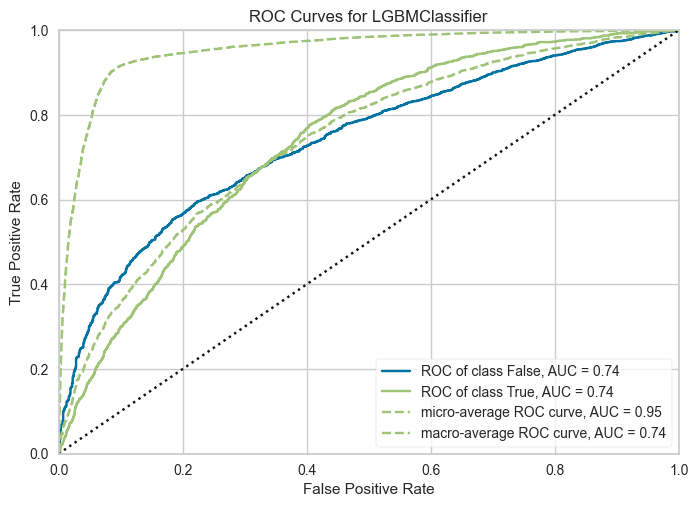

In [87]:
# plotando um grafico do AUC para o modelo tunado
plot_model(tuned_lgbm, plot = 'auc')

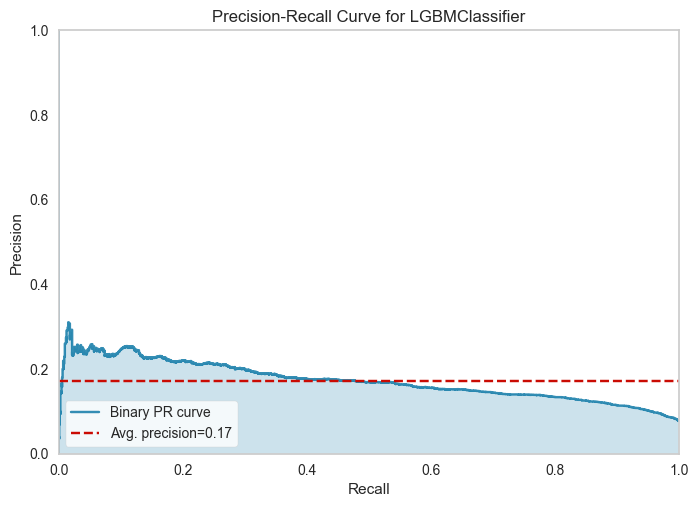

In [88]:
# grafico do Precision-Recall
plot_model(tuned_lgbm, plot = 'pr')

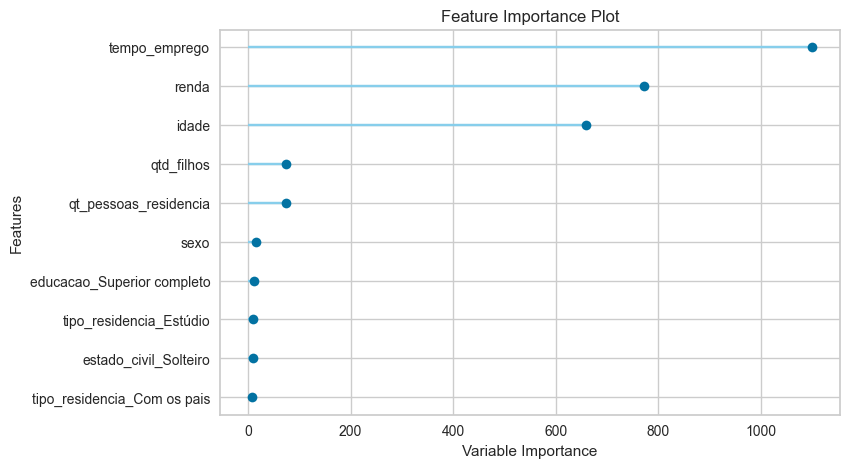

In [89]:
# grafico das variaveis mais importantes segundo o modelo tunado
plot_model(tuned_lgbm, plot='feature')

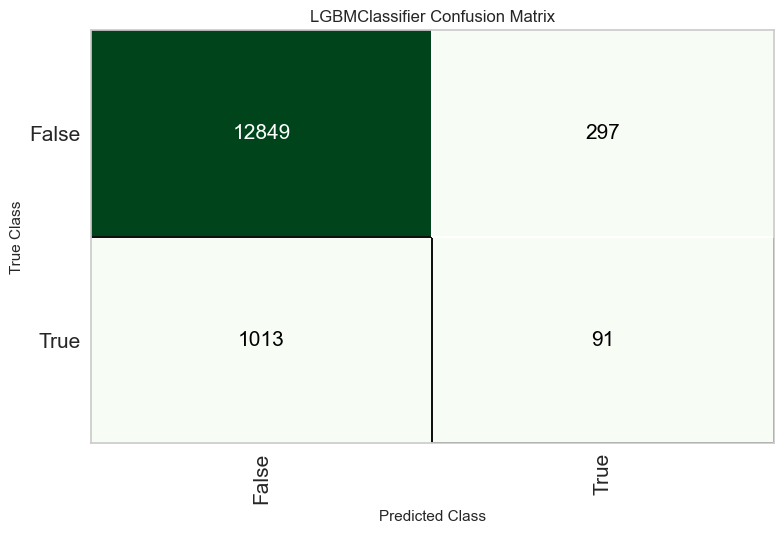

In [90]:
# matriz de confusão para visualizarmos seus erros e acertos
plot_model(tuned_lgbm, plot = 'confusion_matrix')

In [91]:
# fazendo predição nos dados que foram separados pelo proprio pycaret referente aos dados de treino (95% do df original)
# 30% destas observações foram separadas para fazer predições nos dados
predict_model(tuned_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9081,0.7395,0.0824,0.2345,0.1220,0.0851,0.0983


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [92]:
# aqui estamos aplicando o finalize_model que vai treinar o modelo com todos os dados de treino ( inclusive os que ele separou
# como teste dentro do treino para medir os hiperparametros)
final_lgbm = finalize_model(tuned_lgbm)

In [93]:
# agora vamos colocar o modelo final à prova dando a ele dados que ele nunca havia visto antes
# para isso vamos passar os dados contidos em data_unseen que criamos no inicio deste exercício
unseen_predictions = predict_model(final_lgbm, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9080,0.7365,0.0408,0.1600,0.0650,0.0343,0.0434


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [94]:
# conferindo os tipos de variaveis que temos no df acima
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

---

### Salvar o arquivo do modelo treinado

In [96]:
# usando o metodo save_model para salvar sua pipeline caso seja preciso usar ele novamente em outra ocasião.
save_model(final_lgbm,'model_final_lgbm_17_10_2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

---

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.

---